In [1]:
import pickle
from pathlib import Path
import haiku as hk
import jax.numpy as jnp
from jaxpm.nn import CNN
from jax.experimental.ode import odeint
import jax_cosmo as jc
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
from jaxpm.pm import lpt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
sys.path.append("../")

from jaxpm.pm import get_delta

from generate_data import get_linear_field, downsample_field, get_ics, arange_particles_in_mesh, run_simulation
from read_data import get_data, load_datasets
from jaxpm.utils import power_spectrum


Matplotlib is building the font cache; this may take a moment.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Check data stored in files

In [20]:
mesh_lr = 128 
mesh_hr = 256 
box_size = 256.0
n_snapshots = 25
n_particles_sqrt_3 = 128
data_dir = Path(f"/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/data/matched_{mesh_lr}_{mesh_hr}_L{box_size:.1f}_S{n_snapshots}"_Np{n_particles_sqrt_3}/")
n_sims = 1

pos_hr, vel_hr, pot_hr = get_data(
    data_dir=data_dir,
    n_mesh=mesh_hr,
    downsampling_factor=None,
    box_size=box_size,
)
pos_lr, vel_lr, pot_lr = get_data(
    data_dir,
    n_mesh=mesh_lr,
    idx=0,
    box_size=box_size,
)
print(pos_hr.shape)
print(pos_lr.shape)

SyntaxError: unterminated string literal (detected at line 6) (3170946463.py, line 6)

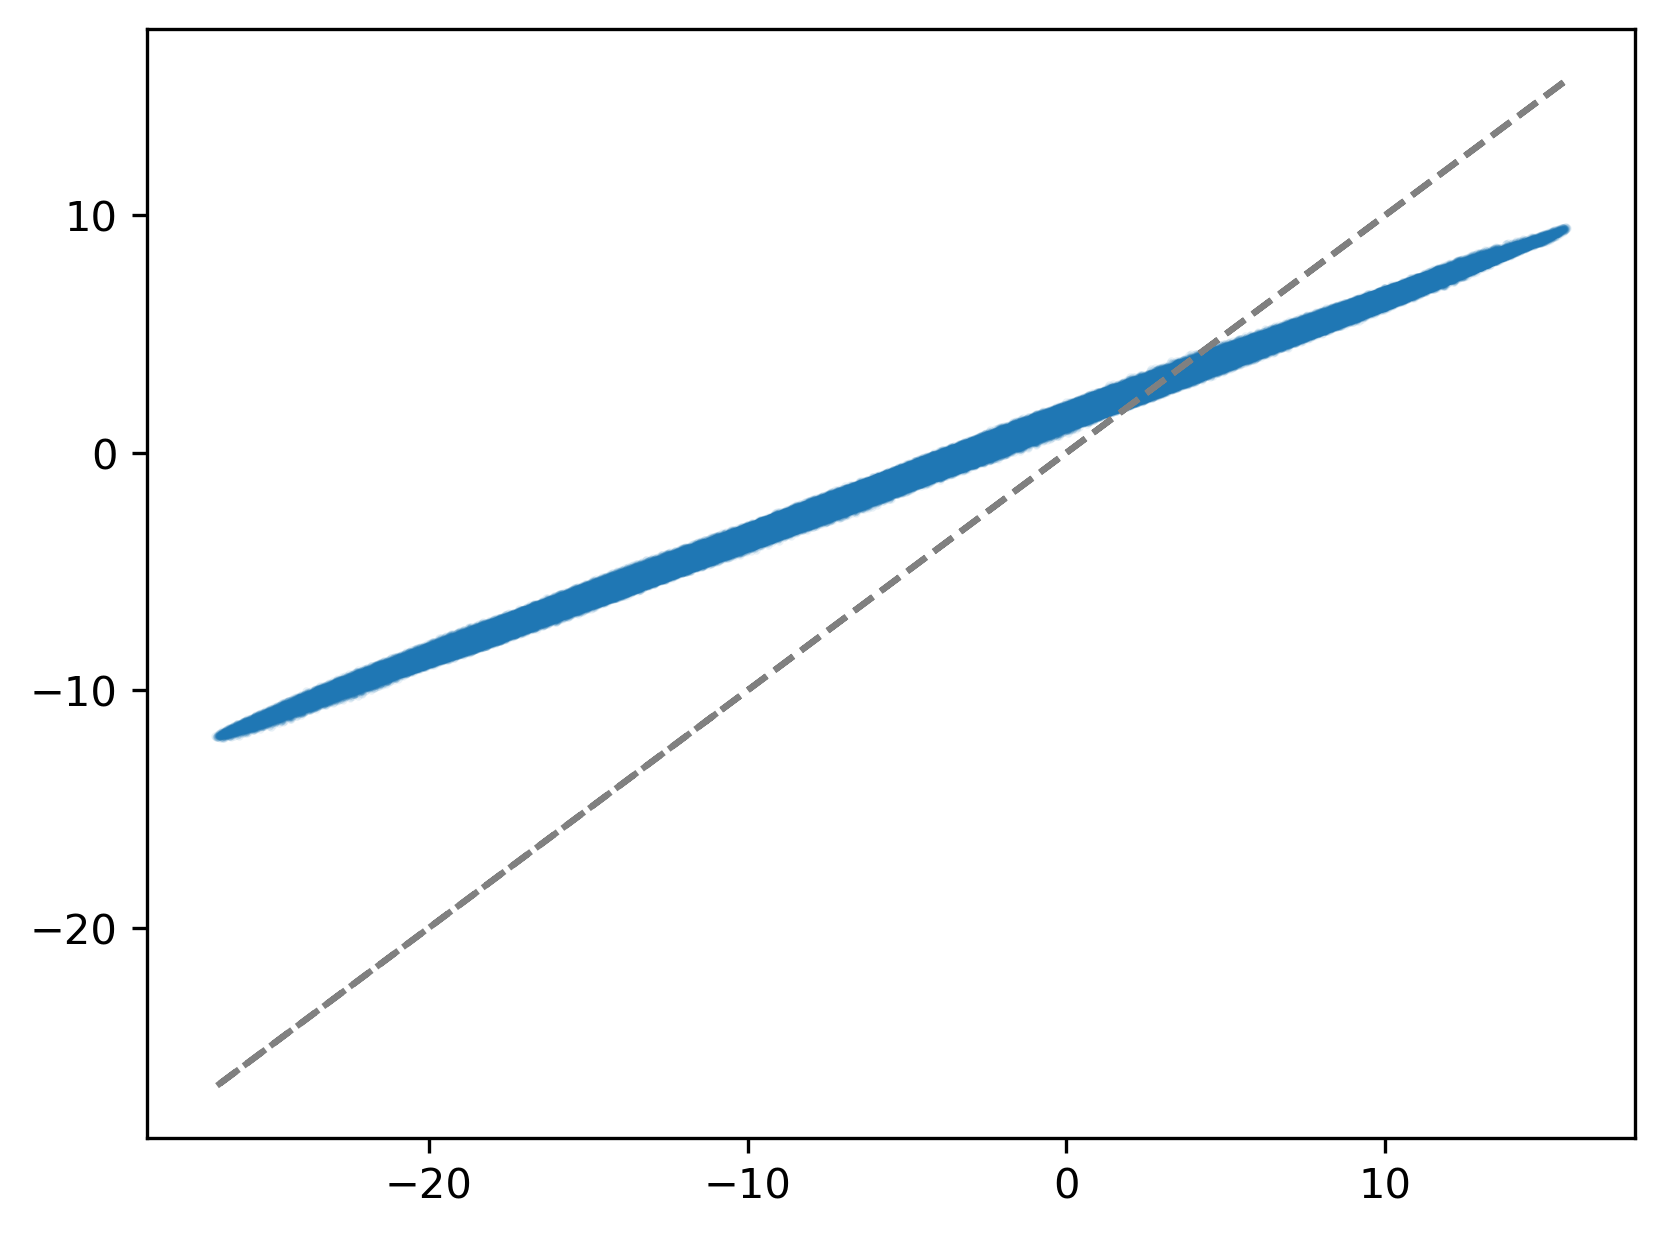

In [ ]:
plt.scatter(
    pot_lr[0].flatten(),#*norm,
    pot_hr[0].flatten(),
    marker='o',
    s=1,
    alpha=0.1
)
plt.plot(
    pot_lr[0].flatten(),
    pot_lr[0].flatten(),
    linestyle='dashed',
    color='gray',
)

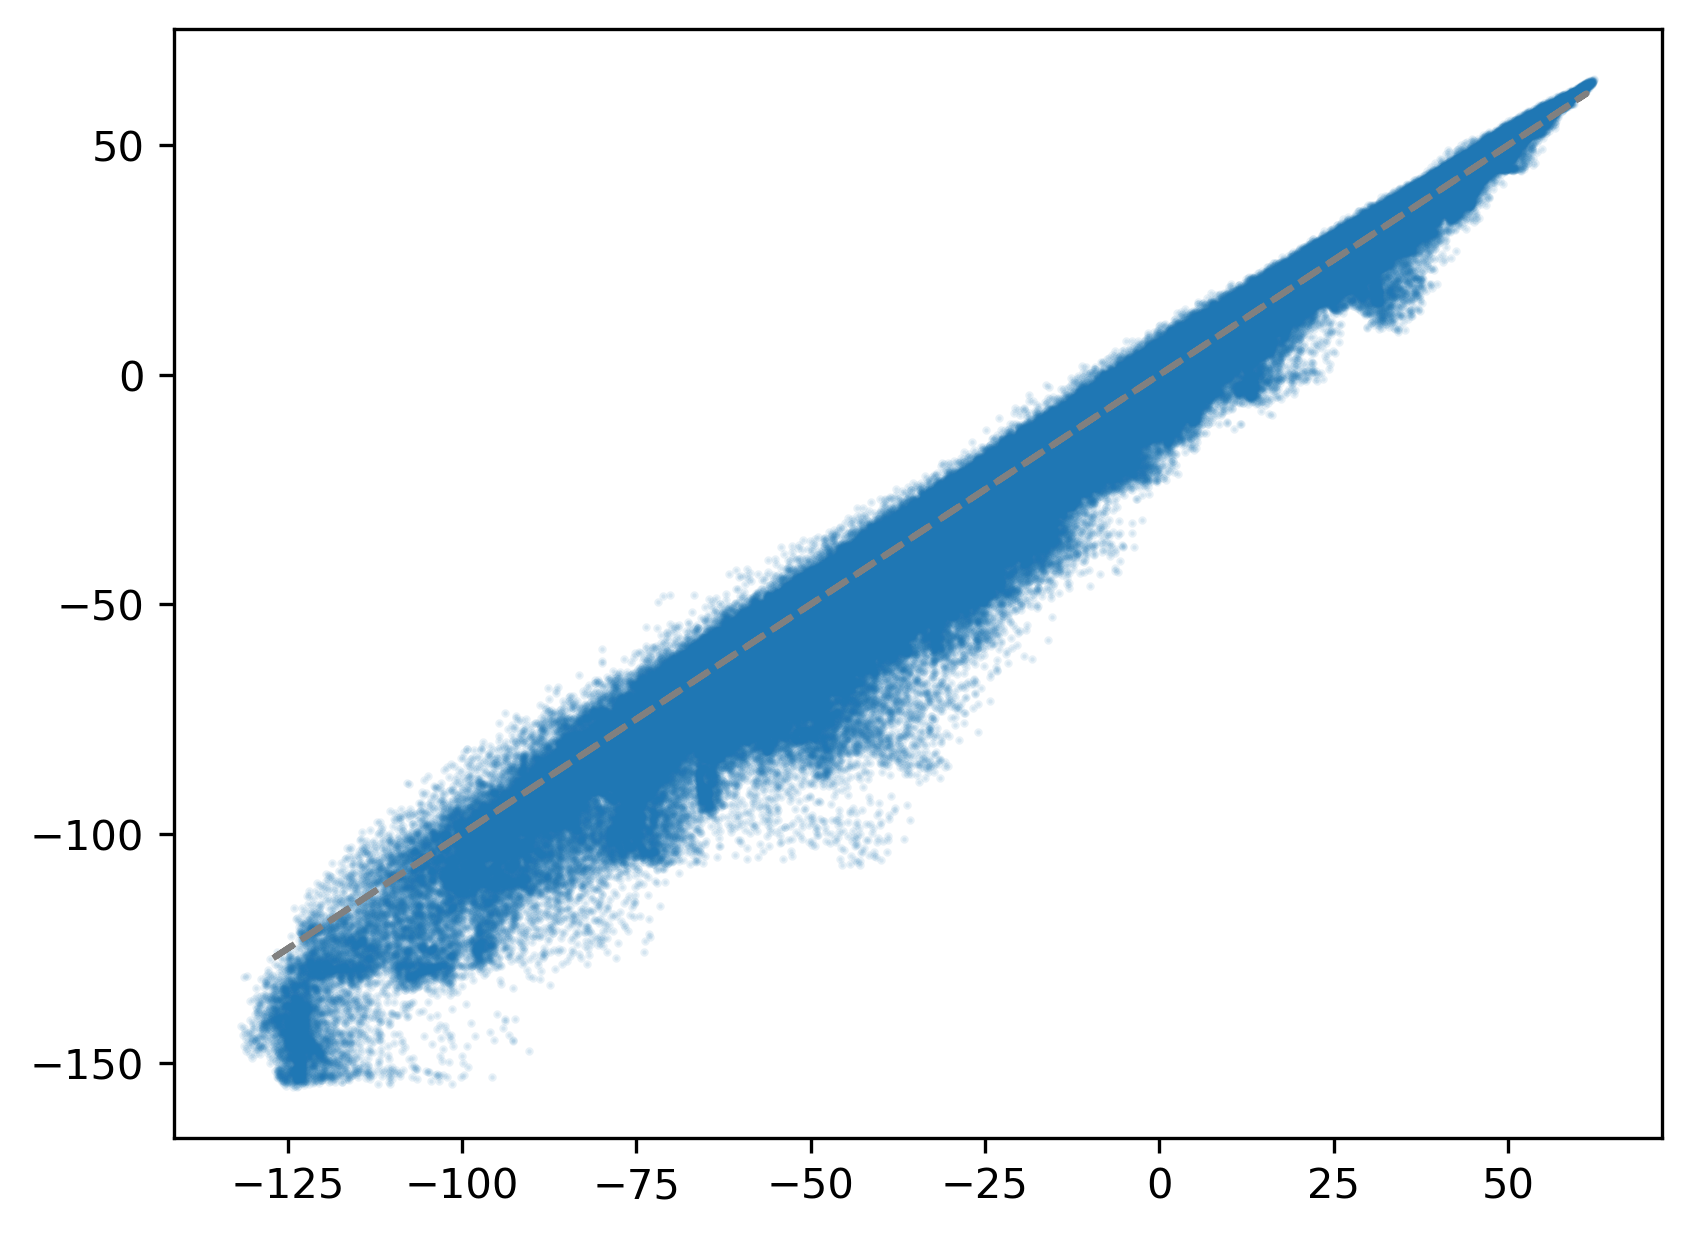

In [ ]:
plt.scatter(
    pot_lr[-1].flatten()/2,#*norm,
    pot_hr[-1].flatten(),
    marker='o',
    s=1,
    alpha=0.1
)
plt.plot(
    pot_lr[-2].flatten()/2,
    pot_lr[-2].flatten()/2,
    linestyle='dashed',
    color='gray',
)

Text(0.5, 1.0, 'HR')

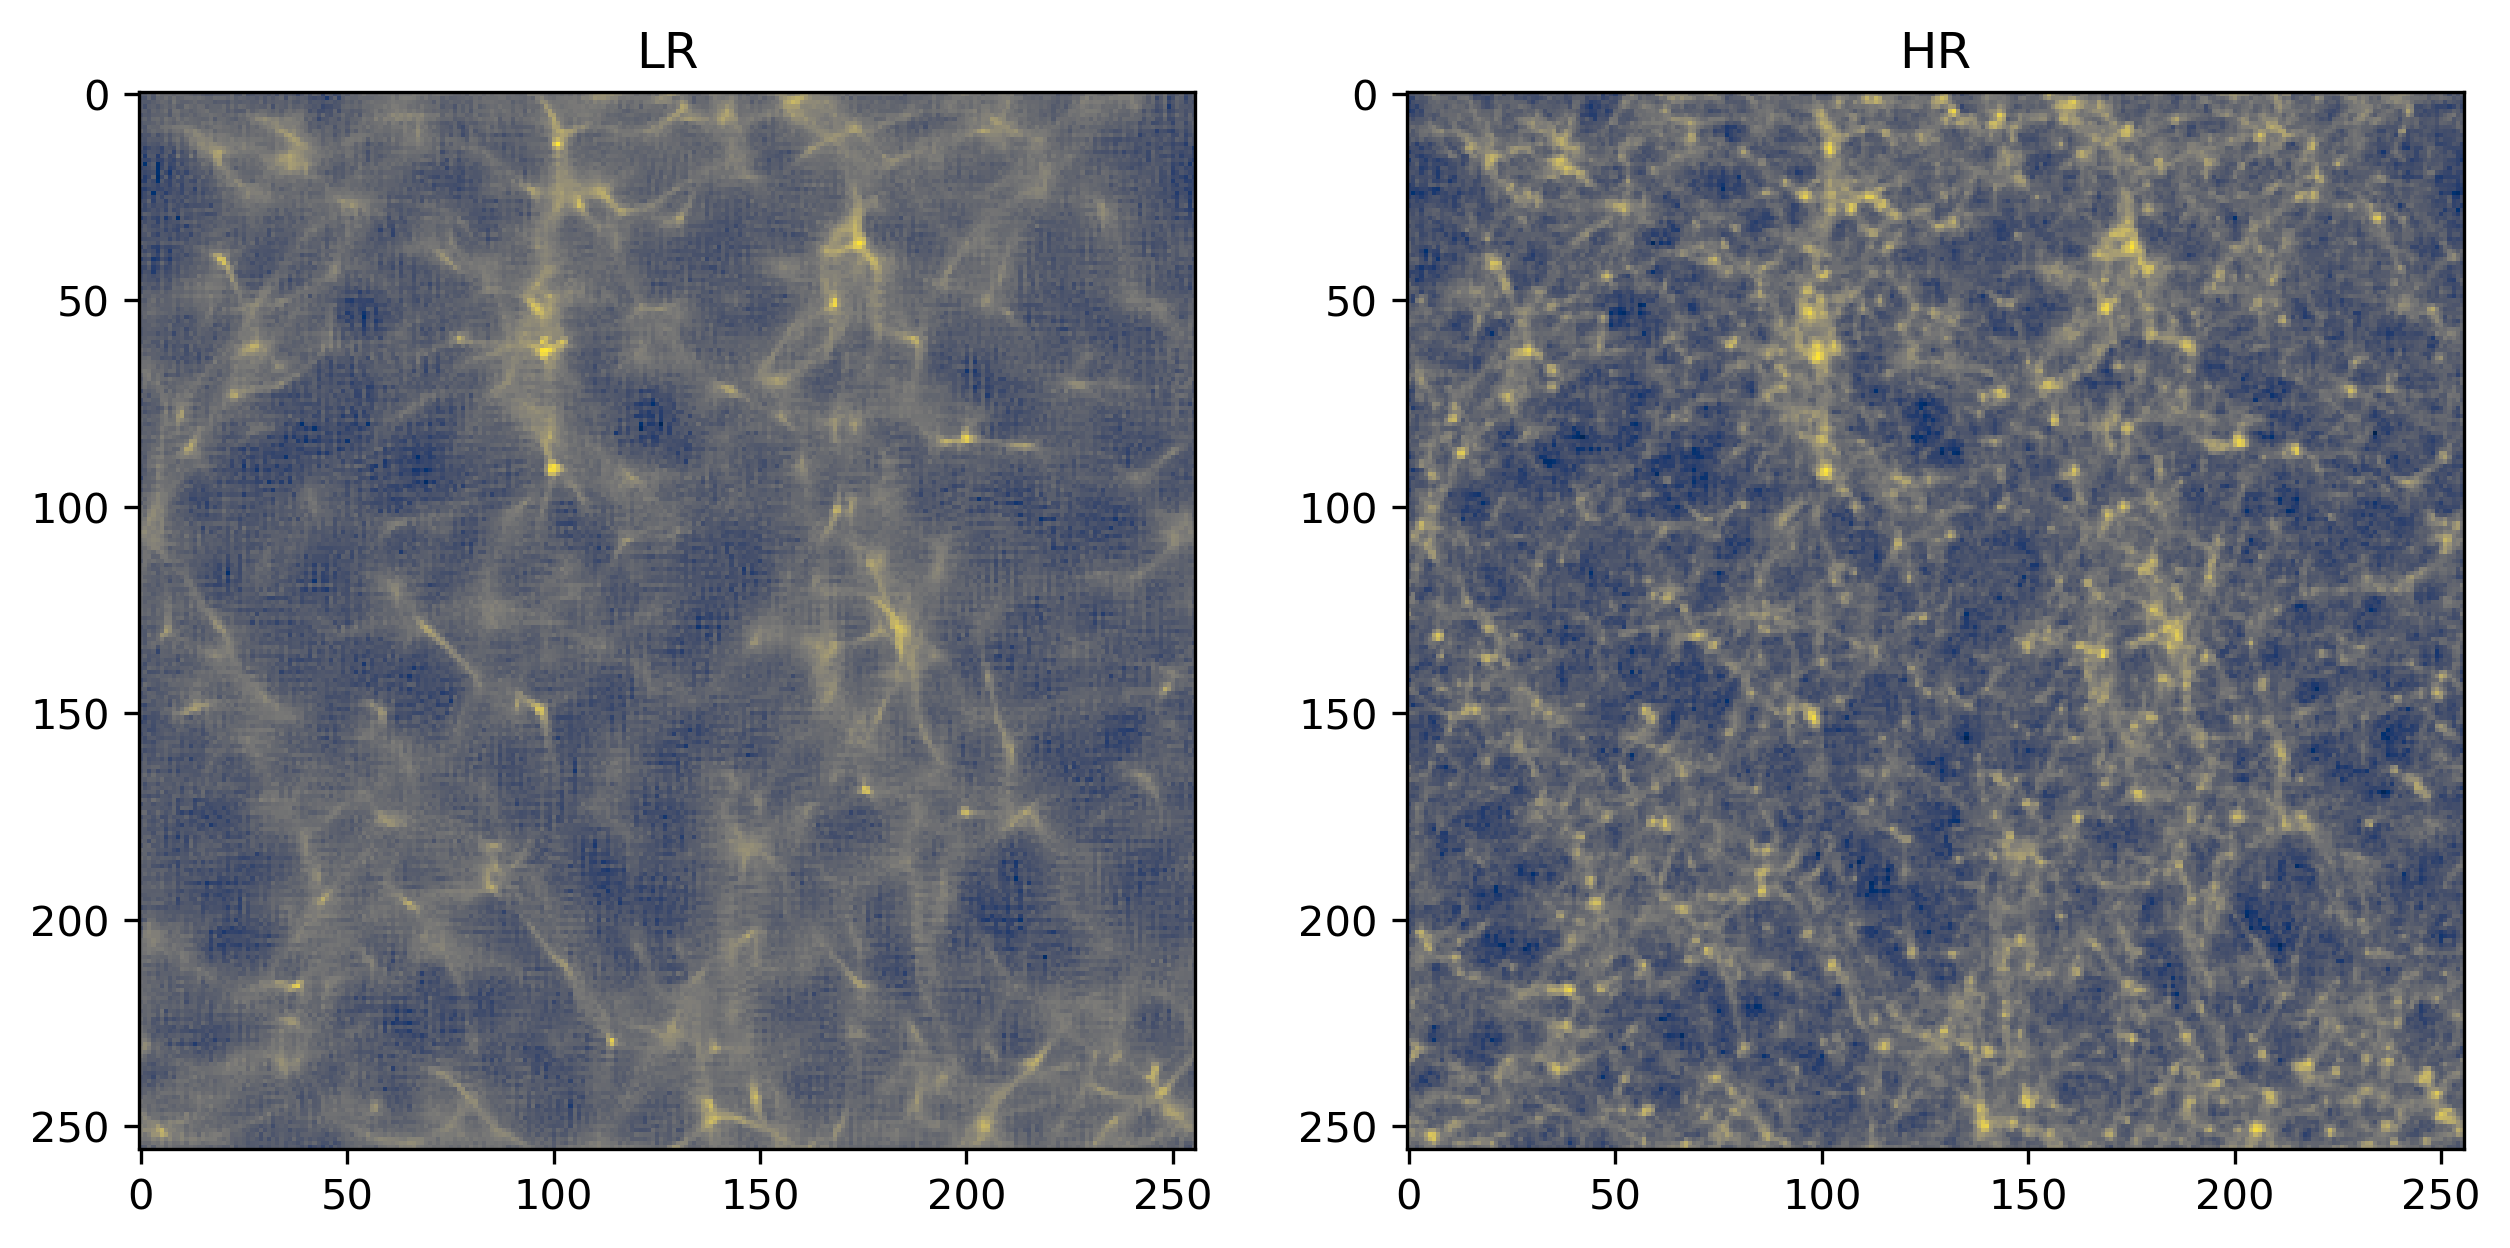

In [22]:
mesh_plot = 256 
cmap = 'cividis'

delta_hr = get_delta(pos_hr[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
norm = LogNorm(
    vmin=delta_hr.sum(axis=0).min(),
    vmax=delta_hr.sum(axis=0).max(),
)
delta_lr = get_delta(pos_lr[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))


fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow((delta_lr[:,:,:]).sum(axis=0),norm=norm, cmap=cmap)

ax[1].imshow((delta_hr[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

ax[0].set_title("LR")
ax[1].set_title("HR")

In [23]:
k, pk_lr = power_spectrum(
      compensate_cic(delta_lr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, pk_hr = power_spectrum(
      compensate_cic(delta_hr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

/n/home11/ccuestalazaro/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


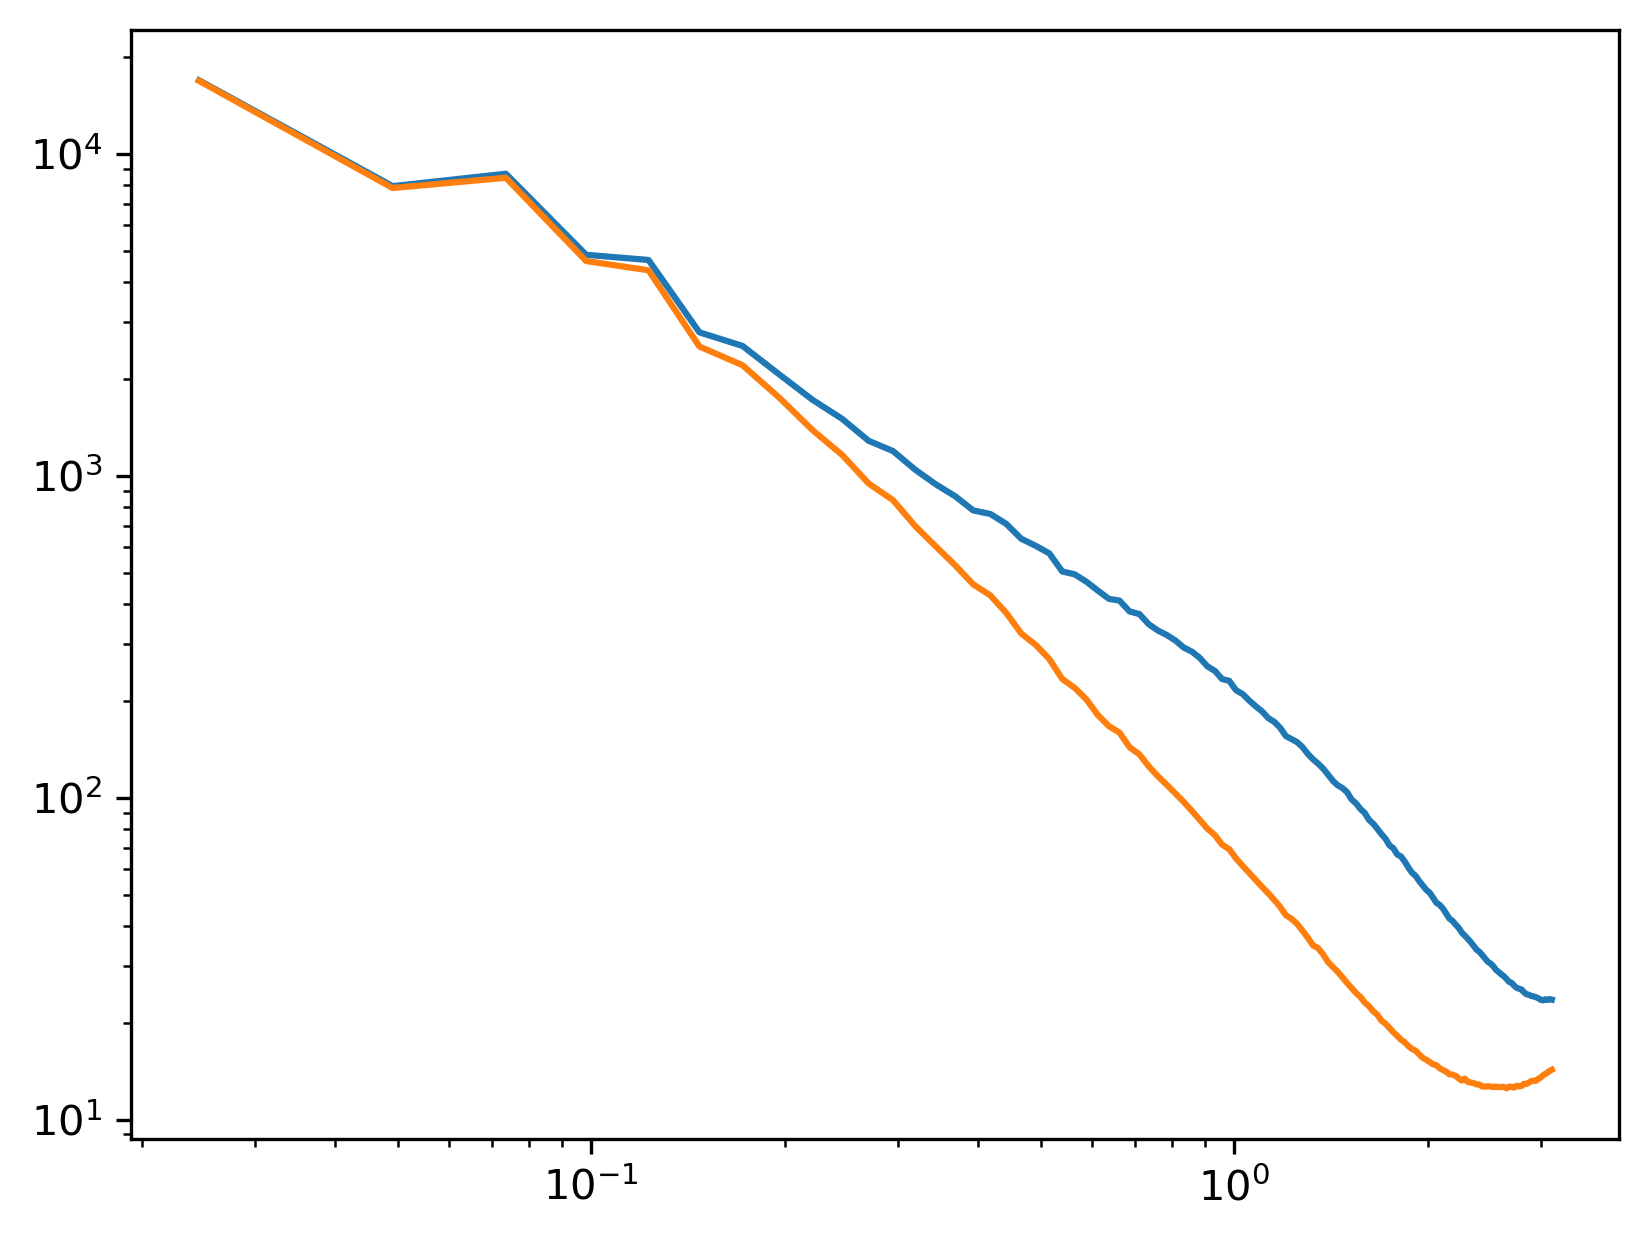

In [24]:
plt.loglog(k, pk_hr)
plt.loglog(k, pk_lr)

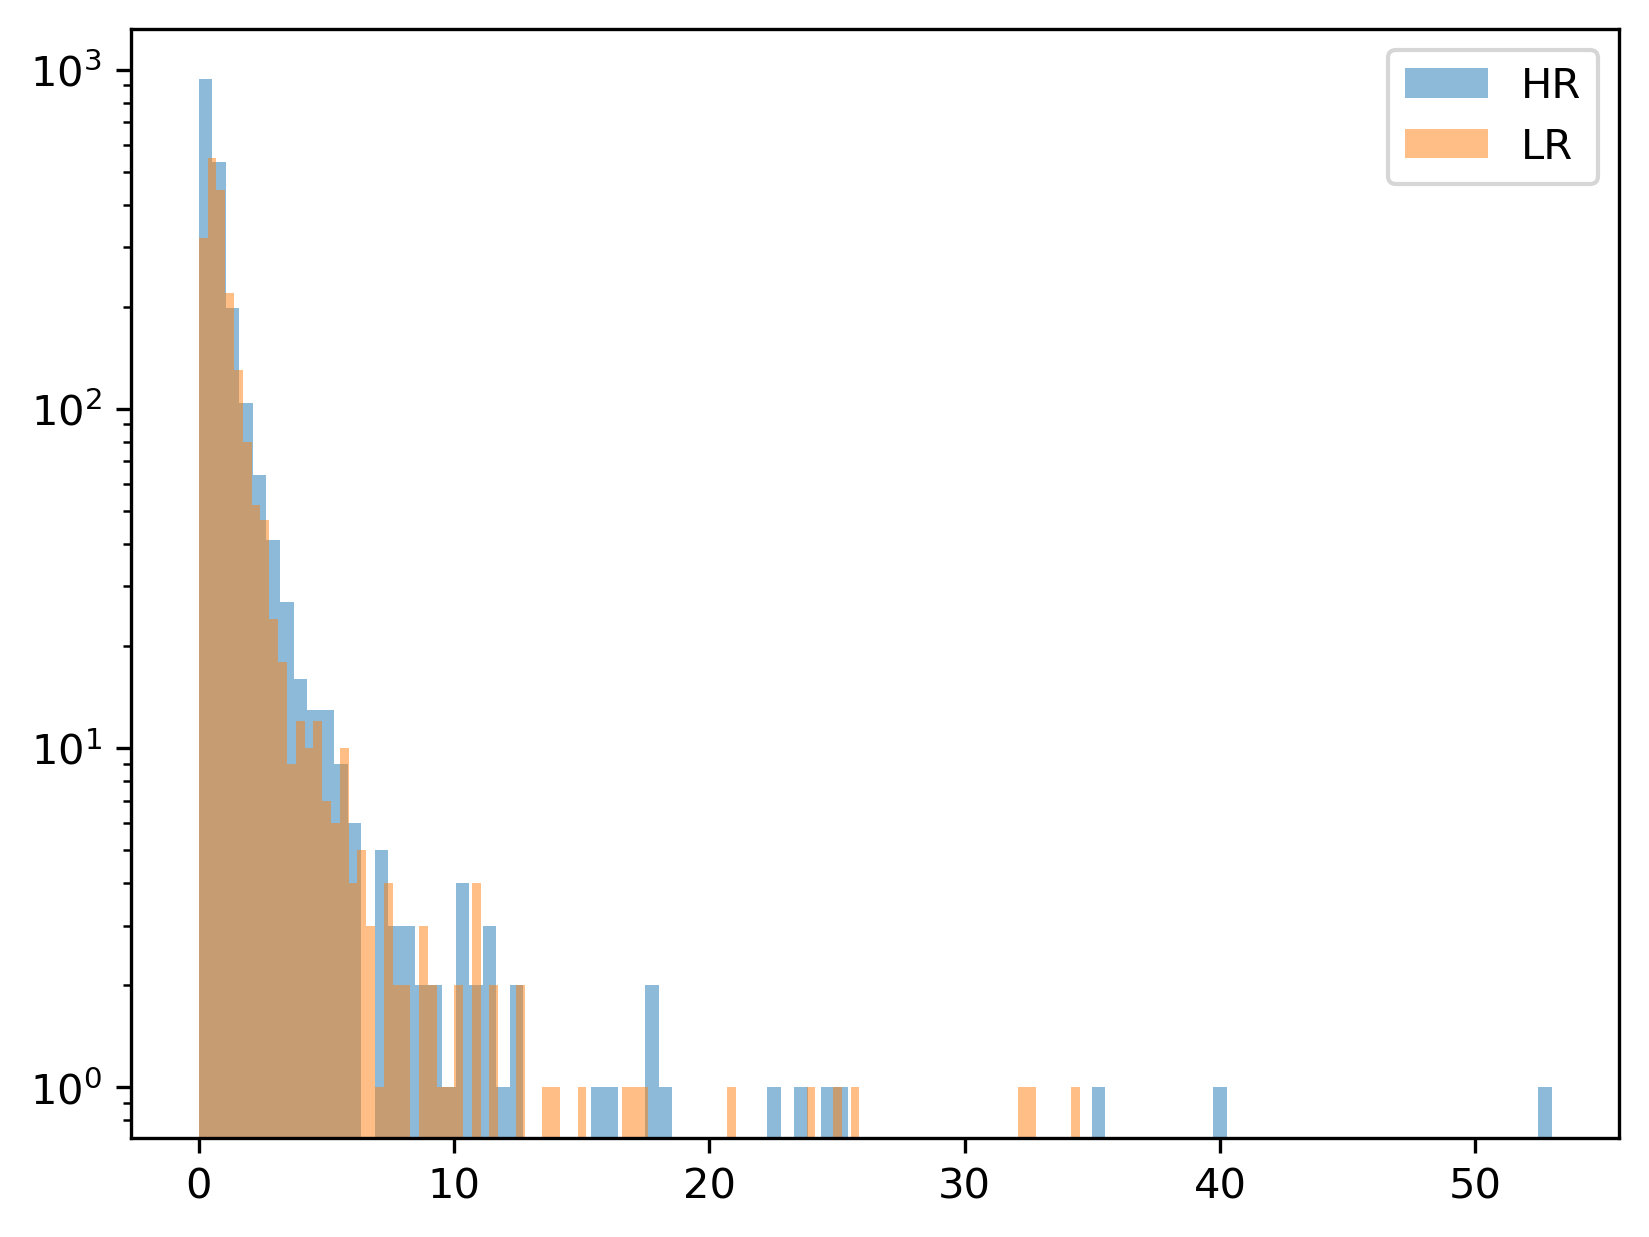

In [11]:
_ = plt.hist(delta_hr.flatten()[:2000], bins=100, alpha=0.5, label="HR", log=True)
_ = plt.hist(delta_lr.flatten()[:2000], bins=100, alpha=0.5, label="LR", log=True)
plt.legend()

## Check dataset as read by network

In [34]:
train_ds, val_ds = load_datasets(1,1,mesh_hr=128,mesh_lr=64,data_dir=data_dir)

In [35]:
hr_ds = train_ds[0]['hr']
lr_ds = train_ds[0]['lr']

Text(0.5, 1.0, 'HR')

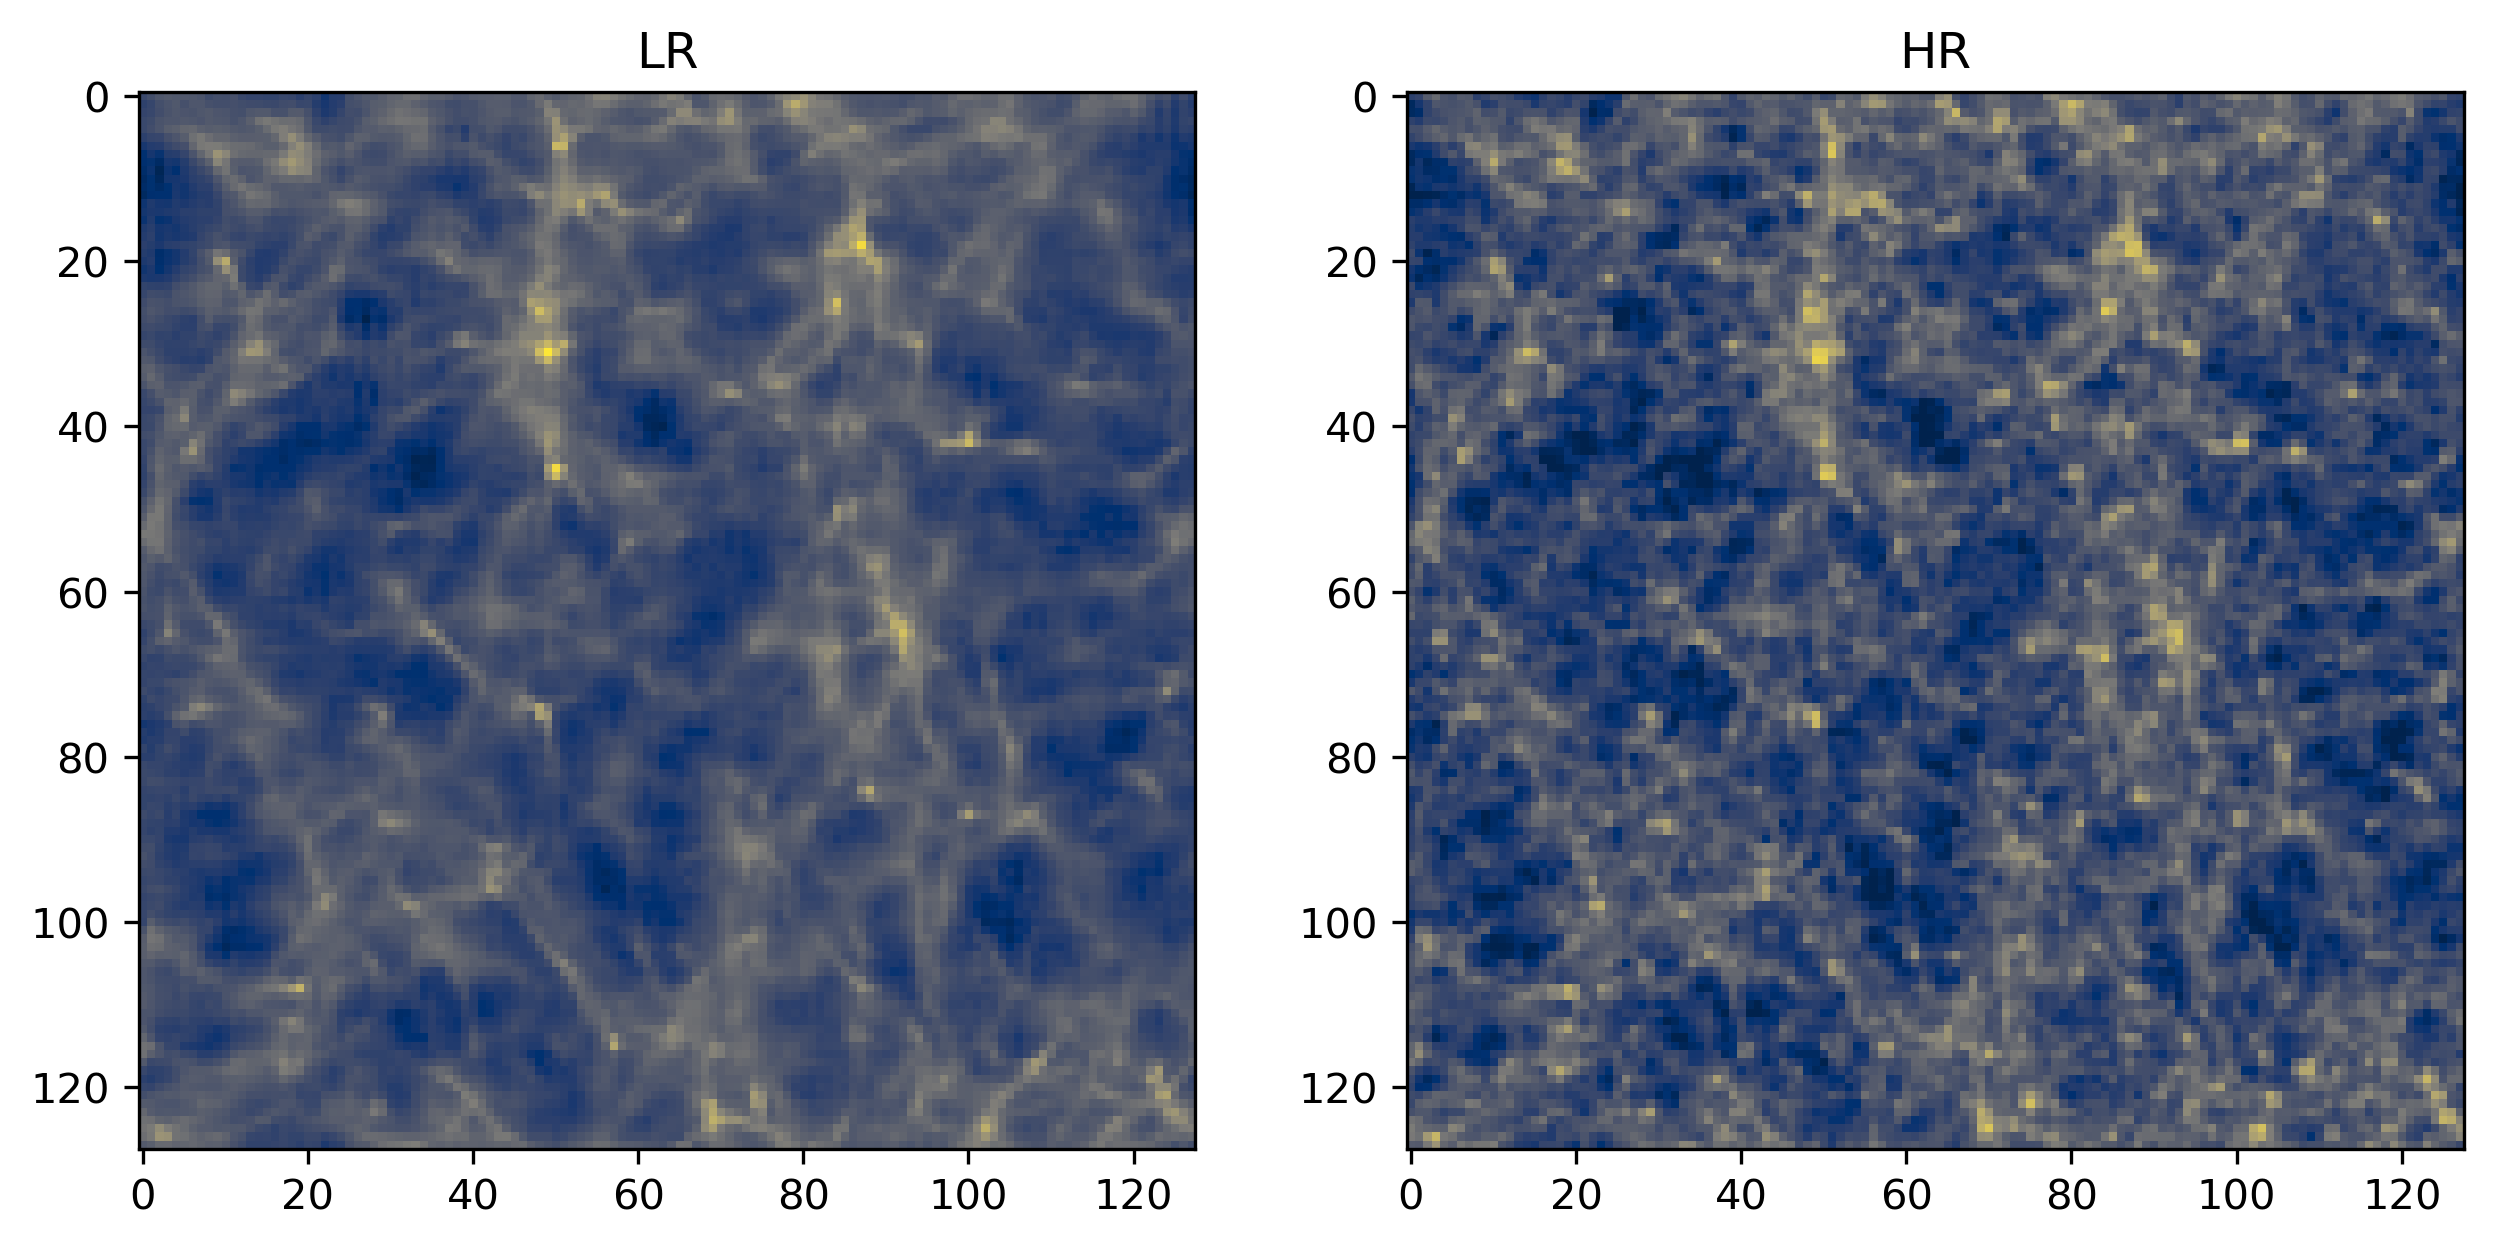

In [36]:
mesh_plot = 128
norm = LogNorm()#(vmin=0, vmax=150) 
cmap = 'cividis'

delta_hr = get_delta(hr_ds.positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_lr = get_delta(lr_ds.positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))


fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow((delta_lr[:,:,:]).sum(axis=0),norm=norm, cmap=cmap)

ax[1].imshow((delta_hr[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

ax[0].set_title("LR")
ax[1].set_title("HR")

Text(0, 0.5, 'LR Pot')

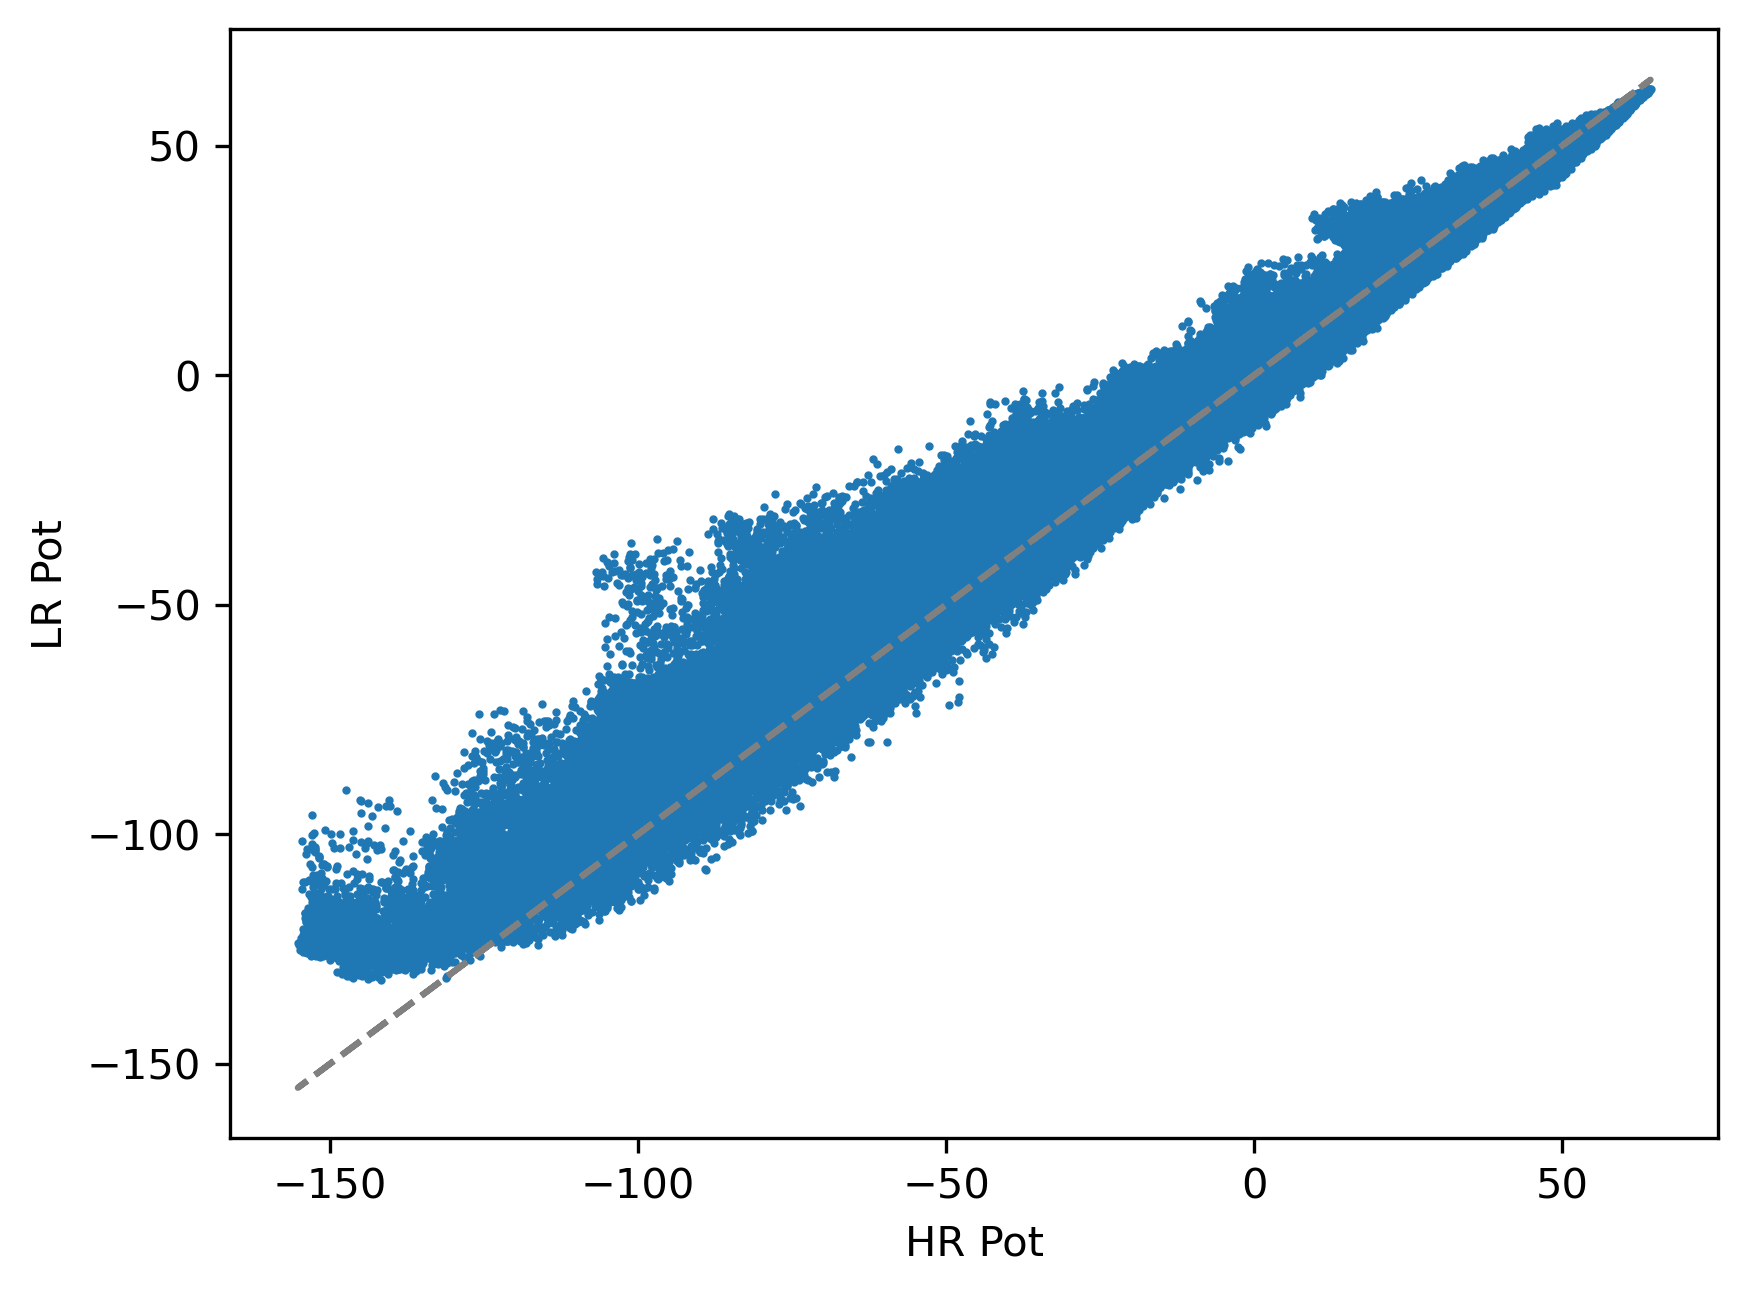

In [40]:
plt.scatter(
    hr_ds.potential[-1],
    lr_ds.potential[-1],
    marker='o', s=1,
)
plt.plot(
    hr_ds.potential[-1],
    hr_ds.potential[-1],
    linestyle='dashed', color='gray'
)
plt.xlabel("HR Pot")
plt.ylabel("LR Pot")

In [33]:
# Compare Pk (is downsampling doing something wrong?)

In [41]:
k, pk_lr = power_spectrum(
      compensate_cic(delta_lr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, pk_hr = power_spectrum(
      compensate_cic(delta_hr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

/n/home11/ccuestalazaro/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:511: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

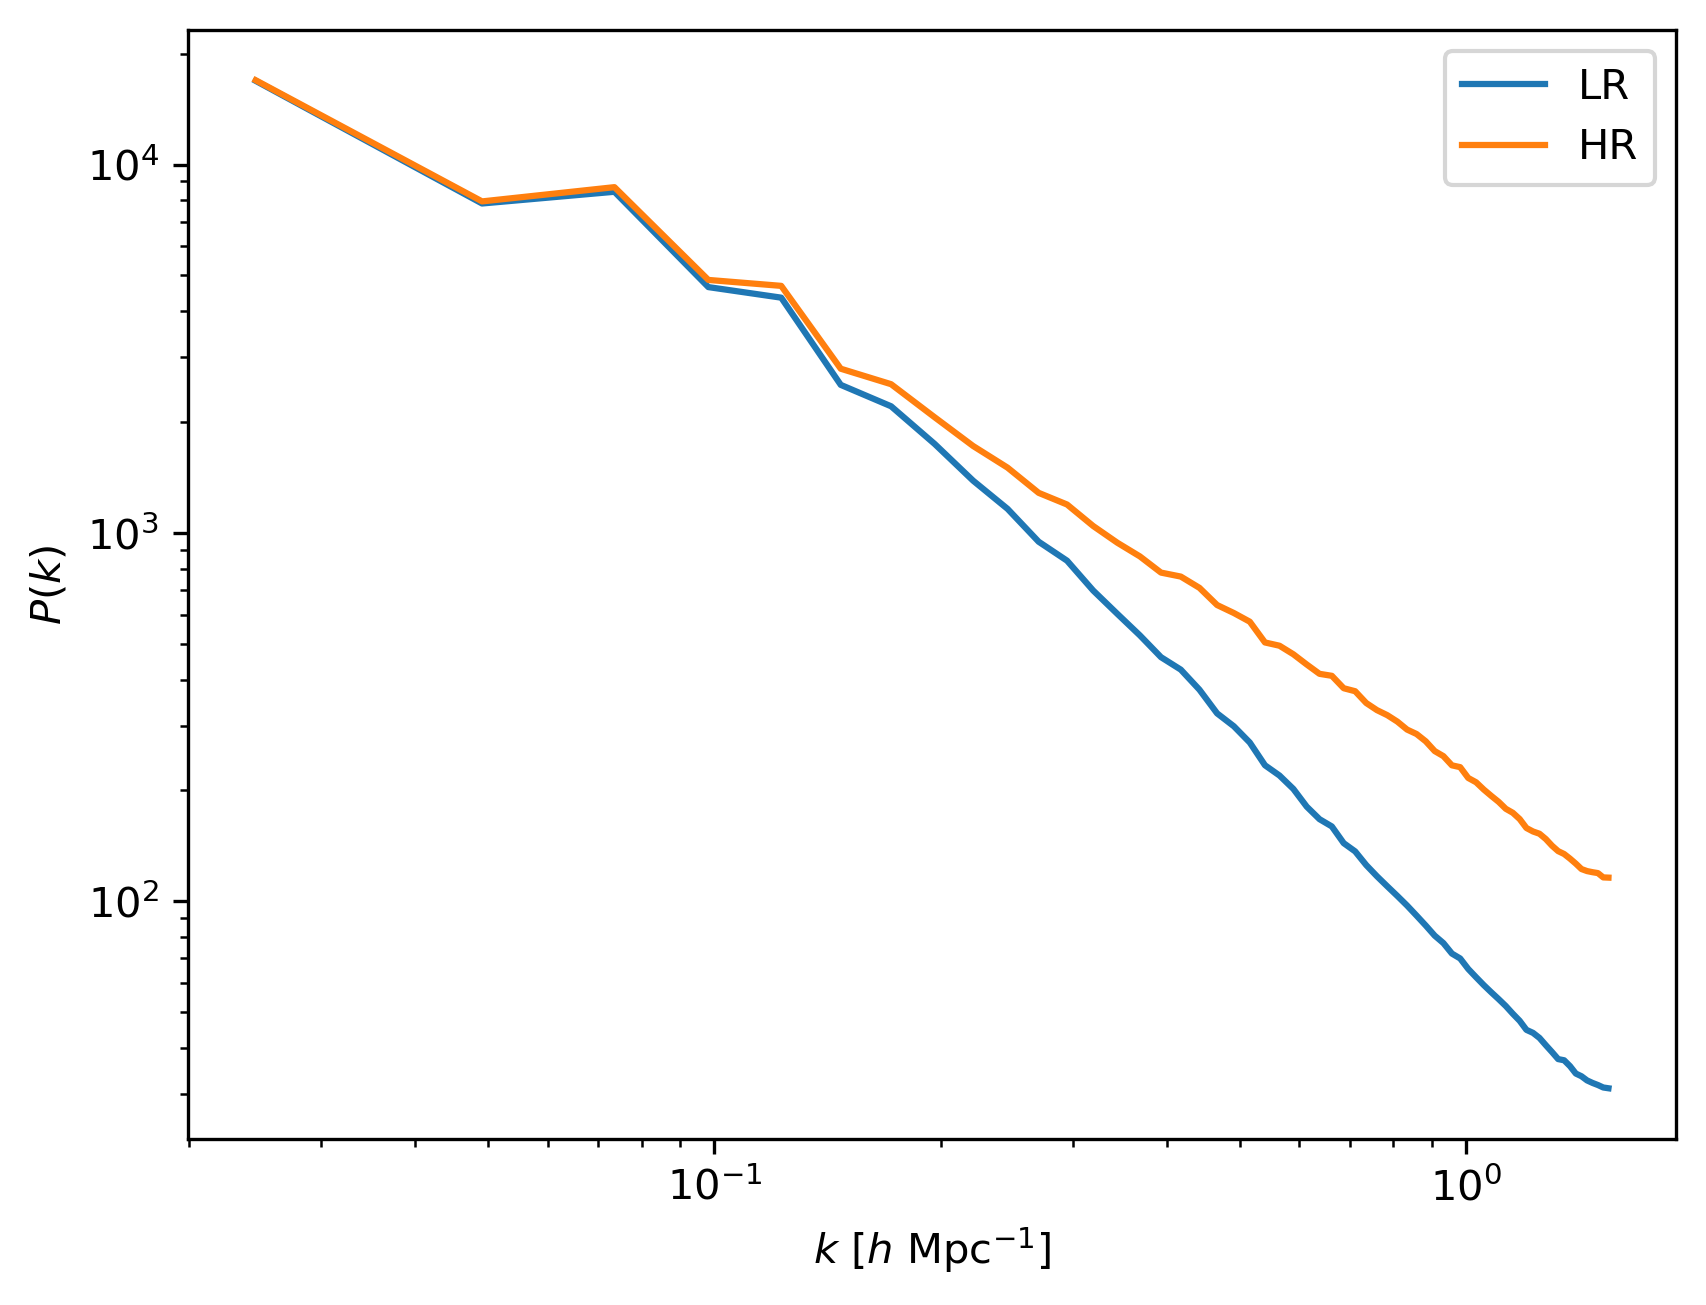

In [42]:
plt.loglog(k,pk_lr, label='LR')
plt.loglog(k,pk_hr, label='HR')
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")